In [1]:
from os import listdir
from os.path import isfile, join
import json
import pandas as pd
import re
from PIL import Image,ImageOps

## Read Json files name

In [224]:
hate_data = [f for f in listdir('hateful_memes') if isfile(join('hateful_memes', f))]

In [225]:
hate_data

['dev_unseen.jsonl',
 'test_seen.jsonl',
 'dev_seen.jsonl',
 'train.jsonl',
 'README.md',
 'NLP_final_projetc_fb.ipynb',
 'LICENSE.txt',
 'test_unseen.jsonl']

### Select json file

In [226]:
josn_files_name = [i for i in hate_data if i.split('.')[1]=='jsonl']

In [227]:
josn_files_name_complete = ['hateful_memes/'+i for i in josn_files_name]
josn_files_name_complete

['hateful_memes/dev_unseen.jsonl',
 'hateful_memes/test_seen.jsonl',
 'hateful_memes/dev_seen.jsonl',
 'hateful_memes/train.jsonl',
 'hateful_memes/test_unseen.jsonl']

### read json file as dict

In [228]:
id_list = []
img_list = []
lable_list = []
text_list = []
wrong_line = []
for i in josn_files_name_complete:
    f = open(i).read()
    f_list = f.split('\n')
    for j in f_list:
        try:
            transfer_to_json = json.loads(str(j))
            id_list.append(transfer_to_json['id'])
            img_list.append('hateful_memes/'+transfer_to_json['img'])
            lable_list.append(transfer_to_json['label'])
            text_list.append(transfer_to_json['text'])
        except:
            wrong_line.append(j)

In [229]:
dataset = pd.DataFrame({'id':id_list, 'img':img_list, 'lable':lable_list, 'text':text_list})
dataset.head()

,id,img,lable,text
0,76432,hateful_memes/img/76432.png,0,you thinking what i'm thinking?
1,14270,hateful_memes/img/14270.png,0,a brilliant mind
2,56947,hateful_memes/img/56947.png,0,"pro gamer 6.000.000 kills, 1 death"
3,35174,hateful_memes/img/35174.png,0,lets end poaching
4,39264,hateful_memes/img/39264.png,0,my wife called me a good husband thats a huge ...


In [230]:
dataset['boostrap'] = 0

### Boostrap to balance dataset

In [232]:
n = len(dataset[dataset.lable==0])-len(dataset[dataset.lable==1])
dataset_lable_1 = dataset[dataset.lable==1].copy()
for i in range(n):
    sample = dataset_lable_1.sample()
    # image_name = sample.img.values[0].split('.')
    # path = image_name[0:-1]
    # new_name = path[0]+str(i)+'.png'
    sample.boostrap = 1
    dataset = dataset.append(sample)

In [233]:
len(dataset[dataset.lable==1])

7834

In [234]:
len(dataset[dataset.lable==0])

7834

In [235]:
dataset = dataset.reset_index(drop=True)
dataset

,id,img,lable,text,boostrap
0,76432,hateful_memes/img/76432.png,0,you thinking what i'm thinking?,0
1,14270,hateful_memes/img/14270.png,0,a brilliant mind,0
2,56947,hateful_memes/img/56947.png,0,"pro gamer 6.000.000 kills, 1 death",0
3,35174,hateful_memes/img/35174.png,0,lets end poaching,0
4,39264,hateful_memes/img/39264.png,0,my wife called me a good husband thats a huge ...,0
...,...,...,...,...,...
15663,61205,hateful_memes/img/61205.png,1,nana addo 2016 compare the difference,1
15664,49615,hateful_memes/img/49615.png,1,no money for them plenty of money for them,1
15665,31769,hateful_memes/img/31769.png,1,what if i told you blacks should not vote,1
15666,18397,hateful_memes/img/18397.png,1,this is why black people can't advance: ni**er...,1


### Split into train and test

In [236]:
train = dataset.sample(frac=0.8, random_state=42)
test = dataset.drop(train.index)

In [237]:
train.head()

,id,img,lable,text,boostrap
9693,84237,hateful_memes/img/84237.png,1,it's hump day!!! oh fuck!!!,0
6554,83504,hateful_memes/img/83504.png,1,look son... another terror attack by peaceful ...,0
10772,96753,hateful_memes/img/96753.png,1,cougars they make great pets,0
10920,01758,hateful_memes/img/01758.png,1,we talked about it i agreed dinner would be r...,0
5938,47506,hateful_memes/img/47506.png,1,"me. saving refugees ""nice try""",0


In [238]:
test.head()

,id,img,lable,text,boostrap
1,14270,hateful_memes/img/14270.png,0,a brilliant mind,0
4,39264,hateful_memes/img/39264.png,0,my wife called me a good husband thats a huge ...,0
5,18564,hateful_memes/img/18564.png,0,early america was cruel,0
9,51940,hateful_memes/img/51940.png,0,giving birth to a baby is one of the most memo...,0
11,30186,hateful_memes/img/30186.png,0,get you a man who will never lay a finger on y...,0


### let image size become same

In [244]:
train_label = list(train.lable)
test_label = list(test.lable)
train_img = list(train.img)
test_img = list(test.img)
train_boostrap = list(train.boostrap)
test_boostrap = list(test.boostrap)

0=not-hateful, 1=hateful

In [245]:
import tensorflow as tf

In [246]:
def is_grey_scale(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return False
    return True

In [249]:
for i in range(len(train_img)):
    imag1 = Image.open(train_img[i])
    if is_grey_scale(train_img[i])==True:
        rgbimg = Image.new("RGBA", imag1.size)
        rgbimg.paste(imag1)
        imag1 = rgbimg
    imag1 = tf.keras.preprocessing.image.smart_resize(
        imag1, (200,200), interpolation='bilinear'
    )
    imag1 = tf.keras.utils.array_to_img(
        imag1, data_format=None, scale=True, dtype=None
    )
    imag1 = imag1.convert('L')
    if train_label[i]==1:
        if train_boostrap[i] == 1:
            imag1.save("fb_train/hate/"+"_"+str(i)+"_"+(train_img[i].split('/'))[-1], 'PNG')
        else:
            imag1.save("fb_train/hate/"+(train_img[i].split('/'))[-1], 'PNG')
    else:
        if train_boostrap[i] == 1:
            imag1.save("fb_train/nothate/"+"_"+str(i)+"_"+(train_img[i].split('/'))[-1], 'PNG')
        else:
            imag1.save("fb_train/nothate/"+(train_img[i].split('/'))[-1], 'PNG')

In [250]:
for i in range(len(test_img)):
    imag1 = Image.open(test_img[i])
    if is_grey_scale(test_img[i])==True:
        rgbimg = Image.new("RGBA", imag1.size)
        rgbimg.paste(imag1)
        imag1 = rgbimg
    imag1 = tf.keras.preprocessing.image.smart_resize(
        imag1, (200,200), interpolation='bilinear'
    )
    imag1 = tf.keras.utils.array_to_img(
        imag1, data_format=None, scale=True, dtype=None
    )
    imag1 = imag1.convert('L')
    if test_label[i]==1:
        if test_boostrap[i] == 1:
            imag1.save("fb_test/hate/"+"_"+str(i)+"_"+(test_img[i].split('/'))[-1], 'PNG')
        else:
            imag1.save("fb_test/hate/"+(test_img[i].split('/'))[-1], 'PNG')
    else:
        if test_boostrap[i] == 1:
            imag1.save("fb_test/nothate/"+"_"+str(i)+"_"+(test_img[i].split('/'))[-1], 'PNG')
        else:
            imag1.save("fb_test/nothate/"+(test_img[i].split('/'))[-1], 'PNG')

# 1. Image Classification

## Build model

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
train_hate = [f for f in listdir('fb_train/hate/') if isfile(join('fb_train/hate/', f))]
train_nothate = [f for f in listdir('fb_train/nothate/') if isfile(join('fb_train/nothate/', f))]
test_hate = [f for f in listdir('fb_test/hate/') if isfile(join('fb_test/hate/', f))]
test_hate = [f for f in listdir('fb_test/hate/') if isfile(join('fb_test/hate/', f))]

In [4]:
train_dataset_name = []
train_dataset_label = []
for i in range(len(train_hate)):
    train_dataset_name.append('fb_train/hate/'+train_hate[i])
    train_dataset_label.append(1)
for i in range(len(train_nothate)):
    train_dataset_name.append('fb_train/nothate/'+train_nothate[i])
    train_dataset_label.append(0)

In [5]:
image_size = (200, 200)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "fb_train",
    image_size=image_size,
    batch_size=batch_size,
)

Found 12268 files belonging to 3 classes.
Metal device set to: Apple M1


2021-12-29 01:06:22.214746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-29 01:06:22.215034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2021-12-29 01:06:22.673907: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


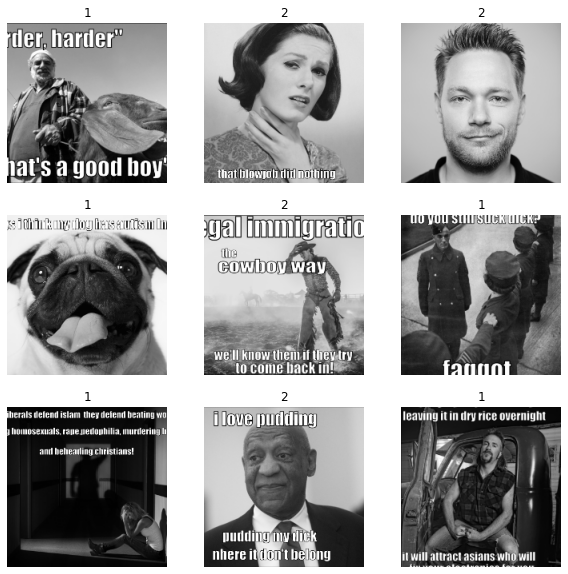

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [9]:
training_set = train_datagen.flow_from_directory('fb_train', target_size=(200, 200), batch_size=100, class_mode='binary', color_mode='grayscale', classes=['hate','nothate'])

Found 12268 images belonging to 2 classes.


In [10]:
test_set = test_datagen.flow_from_directory('fb_test', target_size=(200, 200), batch_size=100, class_mode='binary', color_mode='grayscale', classes=['hate','nothate'])

Found 3120 images belonging to 2 classes.


Have already try denseness, vgg16, resnet, EfficientNetB7, NASNetLarge,InceptionV3 

In [11]:
from keras.applications.densenet import DenseNet201,preprocess_input
from keras.layers import Activation, Dense
base_model = DenseNet201(include_top=False, weights=None,
    input_shape=(200,200,1), pooling=max, classes=2)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
predictions = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(base_model.input, outputs=predictions)


In [12]:
for layer in model.layers:
    layer.trainable=True

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [475]:
model.fit_generator(training_set, steps_per_epoch=120, epochs=10, validation_data=test_set, validation_split=0.1, validation_steps=100)

/var/folders/0f/brs6kj9d6bbftjh0sk1763yh0000gn/T/ipykernel_90428/4204227391.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(training_set, steps_per_epoch=120, epochs=10, validation_data=test_set, validation_steps=100)


Epoch 1/10
120/120 [==============================] - 1608s 13s/step - loss: 0.1328 - accuracy: 0.9460 - val_loss: 1.0149 - val_accuracy: 0.7151
Epoch 2/10
120/120 [==============================] - 1586s 13s/step - loss: 0.1454 - accuracy: 0.9406
Epoch 3/10
120/120 [==============================] - 1573s 13s/step - loss: 0.1236 - accuracy: 0.9505
Epoch 4/10
120/120 [==============================] - 1594s 13s/step - loss: 0.1202 - accuracy: 0.9512
Epoch 5/10
120/120 [==============================] - 1714s 14s/step - loss: 0.1335 - accuracy: 0.9454
Epoch 6/10
120/120 [==============================] - 1690s 14s/step - loss: 0.1134 - accuracy: 0.9528
Epoch 7/10
120/120 [==============================] - 1588s 13s/step - loss: 0.0981 - accuracy: 0.9591
Epoch 8/10
120/120 [==============================] - 1613s 13s/step - loss: 0.1063 - accuracy: 0.9581
Epoch 9/10
120/120 [==============================] - 1839s 15s/step - loss: 0.0995 - accuracy: 0.9580
Epoch 10/10
120/120 [==========

In [476]:
score = model.evaluate(test_set, verbose=0)

In [477]:
print(f'Loss on test:{score[0]}, accuracy on test:{score[1]}')

Loss on test:1.268174409866333, accuracy on test:0.6903846263885498


## Sava and load model

In [478]:
model.save('saved_model/nlp_final_image2')

INFO:tensorflow:Assets written to: saved_model/nlp_final_image2/assets


In [479]:
new_model = tf.keras.models.load_model('saved_model/nlp_final_image2')

In [480]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 100, 100, 64  3136        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Prediction

In [673]:
from keras.preprocessing import image
import numpy as np

## Prediction on our dataset

In [674]:
hate_image = [f for f in listdir('hate') if isfile(join('hate', f))]

In [675]:
nothate_image = [f for f in listdir('NotHate') if isfile(join('NotHate', f))]

In [676]:
import matplotlib.pyplot as plt

In [677]:
def is_grey_scale(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return False
    return True

In [678]:
image_name = []
image_expendarray = []
wrong_file = []
predict_label = []
label_true = []
for i in hate_image:
    try:
        imag1 = image.load_img('hate/'+i)
        if is_grey_scale('hate/'+i)==True:
            rgbimg = Image.new("RGBA", imag1.size)
            rgbimg.paste(imag1)
            imag1 = rgbimg
        imag1 = tf.keras.preprocessing.image.smart_resize(
            imag1, (200,200), interpolation='bilinear'
        )
        imag1 = tf.keras.utils.array_to_img(
            imag1, data_format=None, scale=True, dtype=None
        )
        imag1 = imag1.convert('L')
        imag1 = tf.keras.preprocessing.image.img_to_array(imag1)
        imag1 = np.array([imag1])
        image_name.append(i)
        predict_label.append(float(new_model.predict(imag1)))
        label_true.append(1)
        #imag1.save('ourdata/hate_'+i)
        # imag1 = tf.keras.preprocessing.image.img_to_array(imag1)
        # imag1 = np.expand_dims(imag1[:,:,:], axis=0)
        # result = new_model.predict(imag1)
        # print(result)
        # image_name.append(i)
        # predict_label.append(result[0][0])
    except Exception as e:
        wrong_file.append('hate/'+i)
        print(e)
        print(f'Wrong on hate/{i}')
for i in nothate_image:
    try:
        imag1 = image.load_img('NotHate/'+i)
        if is_grey_scale('NotHate/'+i)==True:
            rgbimg = Image.new("RGBA", imag1.size)
            rgbimg.paste(imag1)
            imag1 = rgbimg
        imag1 = tf.keras.preprocessing.image.smart_resize(
            imag1, (200,200), interpolation='bilinear'
        )
        imag1 = tf.keras.utils.array_to_img(
            imag1, data_format=None, scale=True, dtype=None
        )
        imag1 = imag1.convert('L')
        imag1 = tf.keras.preprocessing.image.img_to_array(imag1)
        imag1 = np.array([imag1])
        image_name.append(i)
        predict_label.append(float(new_model.predict(imag1)))
        label_true.append(0)
        #imag1.save('ourdata/nothate_'+i)
        # imag1 = tf.keras.preprocessing.image.img_to_array(imag1)
        # imag1 = np.expand_dims(imag1[:,:,:], axis=0)
        # result = new_model.predict(np.array(imag1))
        # image_name.append(i)
        # predict_label.append(result[0][0])
    except:
        wrong_file.append('NotHate/'+i)
        print(f'Wrong on Notehate/{i}')

In [679]:
import pandas as pd
predict_data = pd.DataFrame({'image_name':image_name, 'predict_label':predict_label,'label_true':label_true})
predict_data.to_csv('image_validation_set.csv')

In [680]:
np.array(predict_label).sum()

521.7394412515177

In [681]:
predict_data

,image_name,predict_label,label_true
0,truePundit.png,0.973368,1
1,mikeFlynn.png,0.005322,1
2,98f987d38e9dee5a3e8ba7f58b7bf358.jpeg,0.872529,1
3,979f1e0c0f7a4a28b4e599cbe4773a67.jpeg,0.981299,1
4,5f1d57f057eb99efd899e2e7ee609c16.jpeg,0.259855,1
...,...,...,...
884,{785FDCFE-6CC2-4934-9673-03216E9D592A}.jpg,0.834658,0
885,Drunk-Social-Media-infographic.jpg,0.993948,0
886,magaPartyHat.png,0.464875,0
887,creepyGuy.gif,0.544624,0


In [682]:
predict_data.predict_label.median()

0.6740743517875671

In [683]:
predict_data['predict_result'] = predict_data.predict_label.apply(lambda x:1 if float(x)<0.5 else 0)

In [684]:
predict_data.head()

,image_name,predict_label,label_true,predict_result
0,truePundit.png,0.973368,1,0
1,mikeFlynn.png,0.005322,1,1
2,98f987d38e9dee5a3e8ba7f58b7bf358.jpeg,0.872529,1,0
3,979f1e0c0f7a4a28b4e599cbe4773a67.jpeg,0.981299,1,0
4,5f1d57f057eb99efd899e2e7ee609c16.jpeg,0.259855,1,1


In [685]:
label_true1 = predict_data.label_true
predict_result1 = predict_data.predict_result

In [686]:
TP = 0
FP = 0
TN = 0
FN =  0
for i in range(len(label_true1)):
    if label_true1[i] == 1:
        if predict_result1[i] == 1:
            TP+=1
        else:
            FN+=1
    if label_true1[i] == 0:
        if predict_result1[i] == 0:
            TN+=1
        else:
            FP+=1

In [687]:
matrix = np.array([[TP, FN], [FP, TN]])
matrix

array([[ 29,  39],
       [346, 475]])

<AxesSubplot:>

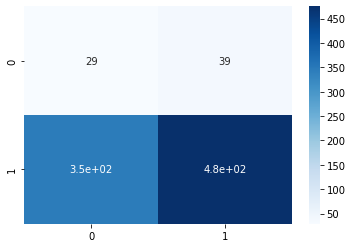

In [688]:
import seaborn as sns
sns.heatmap(matrix, annot = True, cmap='Blues')

In [689]:
precision = TP/(TP+FP)
precision

0.07733333333333334

In [690]:
recall = TP/(TP+FN)
recall

0.4264705882352941

In [691]:
F1 = (2*precision*recall)/(precision+recall)
F1

0.1309255079006772

In [692]:
accuracy = (TP+TN)/(TP+FP+TN+FN)
accuracy

0.5669291338582677

In [693]:
predict_data = predict_data.drop('predict_label', axis=1)

In [694]:
predict_data.to_csv('4.1.image_validation_set_ourdataset.csv')

## Prediction on Facebook dataset

In [695]:
train_hate_image = [f for f in listdir('fb_train/hate') if isfile(join('fb_train/hate', f))]
train_nothate_image = [f for f in listdir('fb_train/NotHate') if isfile(join('fb_train/NotHate', f))]
test_hate_image = [f for f in listdir('fb_test/hate') if isfile(join('fb_test/hate', f))]
test_nothate_image = [f for f in listdir('fb_test/NotHate') if isfile(join('fb_test/NotHate', f))]

In [696]:
image_name = []
image_expendarray = []
wrong_file = []
predict_label = []
label_true = []

In [697]:
for i in train_hate_image:
    try:
        imag1 = image.load_img('fb_train/hate/'+i, color_mode="grayscale")
        imag1 = tf.keras.preprocessing.image.img_to_array(imag1)
        imag1 = np.array([imag1])
        image_name.append(i)
        predict_label.append(float(new_model.predict(imag1)))
        label_true.append(1)
        #imag1.save('ourdata/hate_'+i)
        # imag1 = tf.keras.preprocessing.image.img_to_array(imag1)
        # imag1 = np.expand_dims(imag1[:,:,:], axis=0)
        # result = new_model.predict(imag1)
        # print(result)
        # image_name.append(i)
        # predict_label.append(result[0][0])
    except Exception as e:
        wrong_file.append('hate/'+i)
        print(e)
        print(f'Wrong on hate/{i}')
for i in train_nothate_image:
    try:
        imag1 = image.load_img('fb_train/NotHate/'+i, color_mode="grayscale")
        imag1 = tf.keras.preprocessing.image.img_to_array(imag1)
        imag1 = np.array([imag1])
        image_name.append(i)
        predict_label.append(float(new_model.predict(imag1)))
        label_true.append(0)
        #imag1.save('ourdata/nothate_'+i)
        # imag1 = tf.keras.preprocessing.image.img_to_array(imag1)
        # imag1 = np.expand_dims(imag1[:,:,:], axis=0)
        # result = new_model.predict(np.array(imag1))
        # image_name.append(i)
        # predict_label.append(result[0][0])
    except:
        wrong_file.append('NotHate/'+i)
        print(f'Wrong on Notehate/{i}')

In [698]:
for i in test_hate_image:
    try:
        imag1 = image.load_img('fb_test/hate/'+i, color_mode="grayscale")
        imag1 = tf.keras.preprocessing.image.img_to_array(imag1)
        imag1 = np.array([imag1])
        image_name.append(i)
        predict_label.append(float(new_model.predict(imag1)))
        label_true.append(1)
    except Exception as e:
        wrong_file.append('hate/'+i)
        print(e)
        print(f'Wrong on hate/{i}')
for i in test_nothate_image:
    try:
        imag1 = image.load_img('fb_test/NotHate/'+i, color_mode="grayscale")
        imag1 = tf.keras.preprocessing.image.img_to_array(imag1)
        imag1 = np.array([imag1])
        image_name.append(i)
        predict_label.append(float(new_model.predict(imag1)))
        label_true.append(0)
    except:
        wrong_file.append('NotHate/'+i)
        print(f'Wrong on Notehate/{i}')

In [699]:
import pandas as pd
predict_data = pd.DataFrame({'image_name':image_name, 'predict_label':predict_label,'label_true':label_true})
predict_data.to_csv('image_validation_set.csv')

In [730]:
import numpy as np

In [770]:
predict_data.image_name = predict_data.image_name.apply(lambda x:np.NaN if str(x)[:1]=='_' else x)
predict_data

,Unnamed: 0,image_name,predict_label,label_true
0,0,69351.png,0.140681,1
1,1,NaN,0.099997,1
2,2,79142.png,0.165526,1
3,3,17843.png,0.002134,1
4,4,27980.png,0.031735,1
...,...,...,...,...
15383,15383,87246.png,0.993500,0
15384,15384,76254.png,0.764214,0
15385,15385,32416.png,0.103417,0
15386,15386,56812.png,0.000992,0


In [771]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,Unnamed: 0,image_name,predict_label,label_true
0,0,69351.png,0.140681,1
1,2,79142.png,0.165526,1
2,3,17843.png,0.002134,1
3,4,27980.png,0.031735,1
4,6,24537.png,0.000005,1


In [772]:
np.array(predict_label).sum()

7232.341084656513

In [773]:
predict_data

,Unnamed: 0,image_name,predict_label,label_true
0,0,69351.png,0.140681,1
1,2,79142.png,0.165526,1
2,3,17843.png,0.002134,1
3,4,27980.png,0.031735,1
4,6,24537.png,0.000005,1
...,...,...,...,...
12255,15383,87246.png,0.993500,0
12256,15384,76254.png,0.764214,0
12257,15385,32416.png,0.103417,0
12258,15386,56812.png,0.000992,0


In [774]:
predict_data.predict_label.median()

0.7730328738689423

In [775]:
predict_data['predict_result'] = predict_data.predict_label.apply(lambda x:1 if float(x)<0.5 else 0)

In [776]:
predict_data.head()

,Unnamed: 0,image_name,predict_label,label_true,predict_result
0,0,69351.png,0.140681,1,1
1,2,79142.png,0.165526,1,1
2,3,17843.png,0.002134,1,1
3,4,27980.png,0.031735,1,1
4,6,24537.png,0.000005,1,1


In [777]:
label_true1 = predict_data.label_true
predict_result1 = predict_data.predict_result

In [778]:
TP = 0
FP = 0
TN = 0
FN =  0
for i in range(len(label_true1)):
    if label_true1[i] == 1:
        if predict_result1[i] == 1:
            TP+=1
        else:
            FN+=1
    if label_true1[i] == 0:
        if predict_result1[i] == 0:
            TN+=1
        else:
            FP+=1

In [779]:
matrix = np.array([[TP, FN], [FP, TN]])
matrix

array([[3989,  577],
       [1320, 6374]])

<AxesSubplot:>

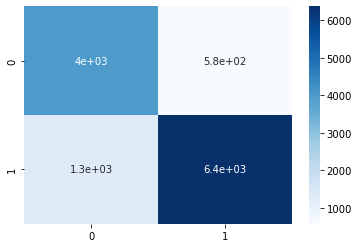

In [780]:
import seaborn as sns
sns.heatmap(matrix, annot = True, cmap='Blues')

In [781]:
precision = TP/(TP+FP)
precision

0.751365605575438

In [782]:
recall = TP/(TP+FN)
recall

0.8736311870346036

In [783]:
F1 = (2*precision*recall)/(precision+recall)
F1

0.8078987341772154

In [784]:
accuracy = (TP+TN)/(TP+FP+TN+FN)
accuracy

0.8452691680261012

In [785]:
predict_data = predict_data.drop('predict_label', axis=1)

In [786]:
predict_data.to_csv('4.2.image_validation_set_FBdataset.csv')